In [1]:
%reload_ext autoreload

%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib.patches import Rectangle

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

import subtle.subtle_io as suio
import subtle.subtle_loss as suloss
import subtle.subtle_metrics as sumetrics
from subtle.dnn.generators import GeneratorUNet2D, GeneratorMultiRes2D
from subtle.data_loaders import SliceLoader
from tqdm import tqdm_notebook as tqdm
from keract import get_activations, display_activations, display_heatmaps
import keras.backend as K

import os
import cv2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)
    

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None, titles=['Pre contrast', 'Low contrast', 'Full Contrast']):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title=titles[1], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title=titles[2], vmin=vmin, vmax=vmax)

    plt.show()

Using TensorFlow backend.
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [15]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/Prisma3.h5'
ims = suio.load_file(fpath_h5)
data_zero, data_low, data_full = ims.transpose(1, 0, 2, 3)

In [16]:
K.clear_session()

ckp_file = '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_mask_smooth.checkpoint'
data_loader = SliceLoader(
    data_list=[fpath_h5], batch_size=1, shuffle=False, verbose=1,
    slices_per_input=7, resize=240, slice_axis=[0]
)

loss_function = suloss.mixed_loss(l1_lambda=0.3, ssim_lambda=0.3)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

model = GeneratorUNet2D(
    num_channel_output=1, num_filters_first_conv=32, num_poolings=3,
    loss_function=loss_function, metrics_monitor=metrics_monitor,
    batch_norm=False, verbose=1, checkpoint_file=ckp_file,
    img_rows=240, img_cols=240, num_channel_input=14
)

model.load_weights()

Building standard model...
Tensor("input_1:0", shape=(?, 240, 240, 14), dtype=float32)
Tensor("re_lu_3/Relu:0", shape=(?, 240, 240, 32), dtype=float32) Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 120, 120, 32), dtype=float32)
Tensor("re_lu_6/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 60, 60, 64), dtype=float32)
Tensor("re_lu_9/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 30, 30, 128), dtype=float32)
conv center before add Tensor("re_lu_10/Relu:0", shape=(?, 30, 30, 128), dtype=float32)
conv center... Tensor("add_1/add:0", shape=(?, 30, 30, 128), dtype=float32)
Tensor("re_lu_13/Relu:0", shape=(?, 60, 60, 128), dtype=float32) Tensor("concatenate_1/concat:0", shape=(?, 60, 60, 256), dtype=float32)
Tensor("re_lu_16/Relu:0", shape=(?, 120, 120, 64), dtype=float32) Tensor("concatenate_2/concat:0", shape=(?, 120, 120, 192), dtype=float32)
Tensor("re_lu_19/Relu:0", shape=(?, 240, 240, 32), dt

loading weights from /home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/enh_mask_smooth.checkpoint


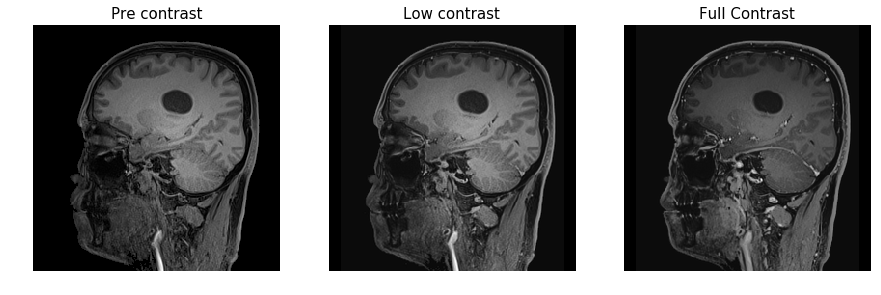

In [17]:
pidx = 75
glen = data_loader.__len__()

ims_mod_zero = np.copy(ims)
ims_mod_low = np.copy(ims)

ims_mod_zero[:, 0] = ims_mod_zero[:, 0] * 0
ims_mod_low[:, 1] = ims_mod_low[:, 1] * 0

show_gad_comparison(ims[pidx, 0], ims[pidx, 1], ims[pidx, 2])

In [18]:
ypred = []
ypred_mod_zero = []
ypred_mod_low = []

for idx in tqdm(range(glen), total=glen):
    item, _ = data_loader.__getitem__(idx, data_npy=ims)
    item_mod_zero, _ = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
    item_mod_low, _ = data_loader.__getitem__(idx, data_npy=ims_mod_low)
    ypred.extend(model.model.predict(item, verbose=0))
    ypred_mod_zero.extend(model.model.predict(item_mod_zero, verbose=0))
    ypred_mod_low.extend(model.model.predict(item_mod_low, verbose=0))
ypred = np.array(ypred)
ypred_mod_zero = np.array(ypred_mod_zero)
ypred_mod_low = np.array(ypred_mod_low)

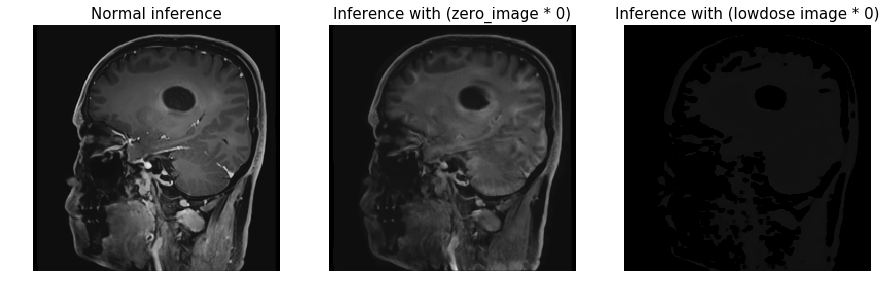

In [19]:
# show_comparison(ims[pidx, 2], ypred[pidx, ..., 0])

show_gad_comparison(
    ypred[pidx, ..., 0], ypred_mod_zero[pidx, ..., 0], ypred_mod_low[pidx, ..., 0], 
    vmin=ims.min(), vmax=ims.max(),
    titles=['Normal inference', 'Inference with (zero_image * 0)', 'Inference with (lowdose image * 0)']
)

### Layer activations

In [19]:
nw_ip, full_img = data_loader.__getitem__(70)

m = model.model
lnames = [layer.name for layer in m.layers]
activations = {k.split('/')[0]: v for k, v in get_activations(model.model, nw_ip).items()}

getact = lambda l: activations[l][0].transpose(2, 0, 1)
k='leaky_re_lu_10'

act = getact(k)

diff_img = nw_ip[0, ..., 10] - nw_ip[0, ..., 3]

disp_act = activations[k][0].transpose(2, 0, 1)
disp_act_img = np.array([cv2.resize(fl, dsize=(240, 240), interpolation=cv2.INTER_CUBIC) for fl in disp_act])

In [20]:
@interact
def show_hmap(idx=(0, 127, 1), alpha=(0, 1, 0.1)):
    plt.imshow(full_img[0, ..., 0])
    plt.imshow(disp_act_img[idx], alpha=alpha, cmap='afmhot')
    plt.show()

interactive(children=(IntSlider(value=63, description='idx', max=127), FloatSlider(value=0.0, description='alp…

### SSIM Comparison

Predicting for scale 1.0



Predicting for scale 1.05



Predicting for scale 1.1



Predicting for scale 1.15



Predicting for scale 1.2



Predicting for scale 1.25



Predicting for scale 1.3



Predicting for scale 1.35



Predicting for scale 1.4



Predicting for scale 1.45



Predicting for scale 1.5



Predicting for scale 1.55



Predicting for scale 1.6



Predicting for scale 1.65



Predicting for scale 1.7000000000000002



Predicting for scale 1.75



Predicting for scale 1.8



Predicting for scale 1.85



Predicting for scale 1.9



Predicting for scale 1.9500000000000002



Predicting for scale 2.0


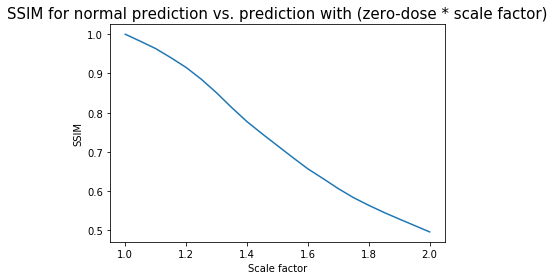

In [43]:
mod_preds = []

dirpath_npy = '/home/srivathsa/projects/studies/gad/tiantan/inference/test/scale'

for sf in np.linspace(1, 2, 21):
    print('Predicting for scale {}'.format(sf))
    ims_mod_zero = np.copy(ims)
    ims_mod_zero[:, 1] *= sf
    
    ypred_mod = []
    for idx in tqdm(range(glen), total=glen):
        item_mod, _ = data_loader.__getitem__(idx, data_npy=ims_mod_zero)
        ypred_mod.extend(model.model.predict(item_mod, verbose=0))
    ypred_mod = np.array(ypred_mod)
    np.save('{}/low_predmod_{:.2f}.npy'.format(dirpath_npy, sf), ypred_mod[..., 0])
    
    mod_preds.append(ypred_mod)
mod_preds = np.array(mod_preds)

ssims = []

for pred in range(mod_preds.shape[0]):
    ssims.append(sumetrics.ssim(ypred[98, ..., 0], mod_preds[pred, 98, ..., 0]))

plt.plot(np.linspace(1, 2, 21), ssims)
plt.xlabel('Scale factor')
plt.ylabel('SSIM')
plt.title('SSIM for normal prediction vs. prediction with (zero-dose * scale factor)', fontsize=15)
plt.show()

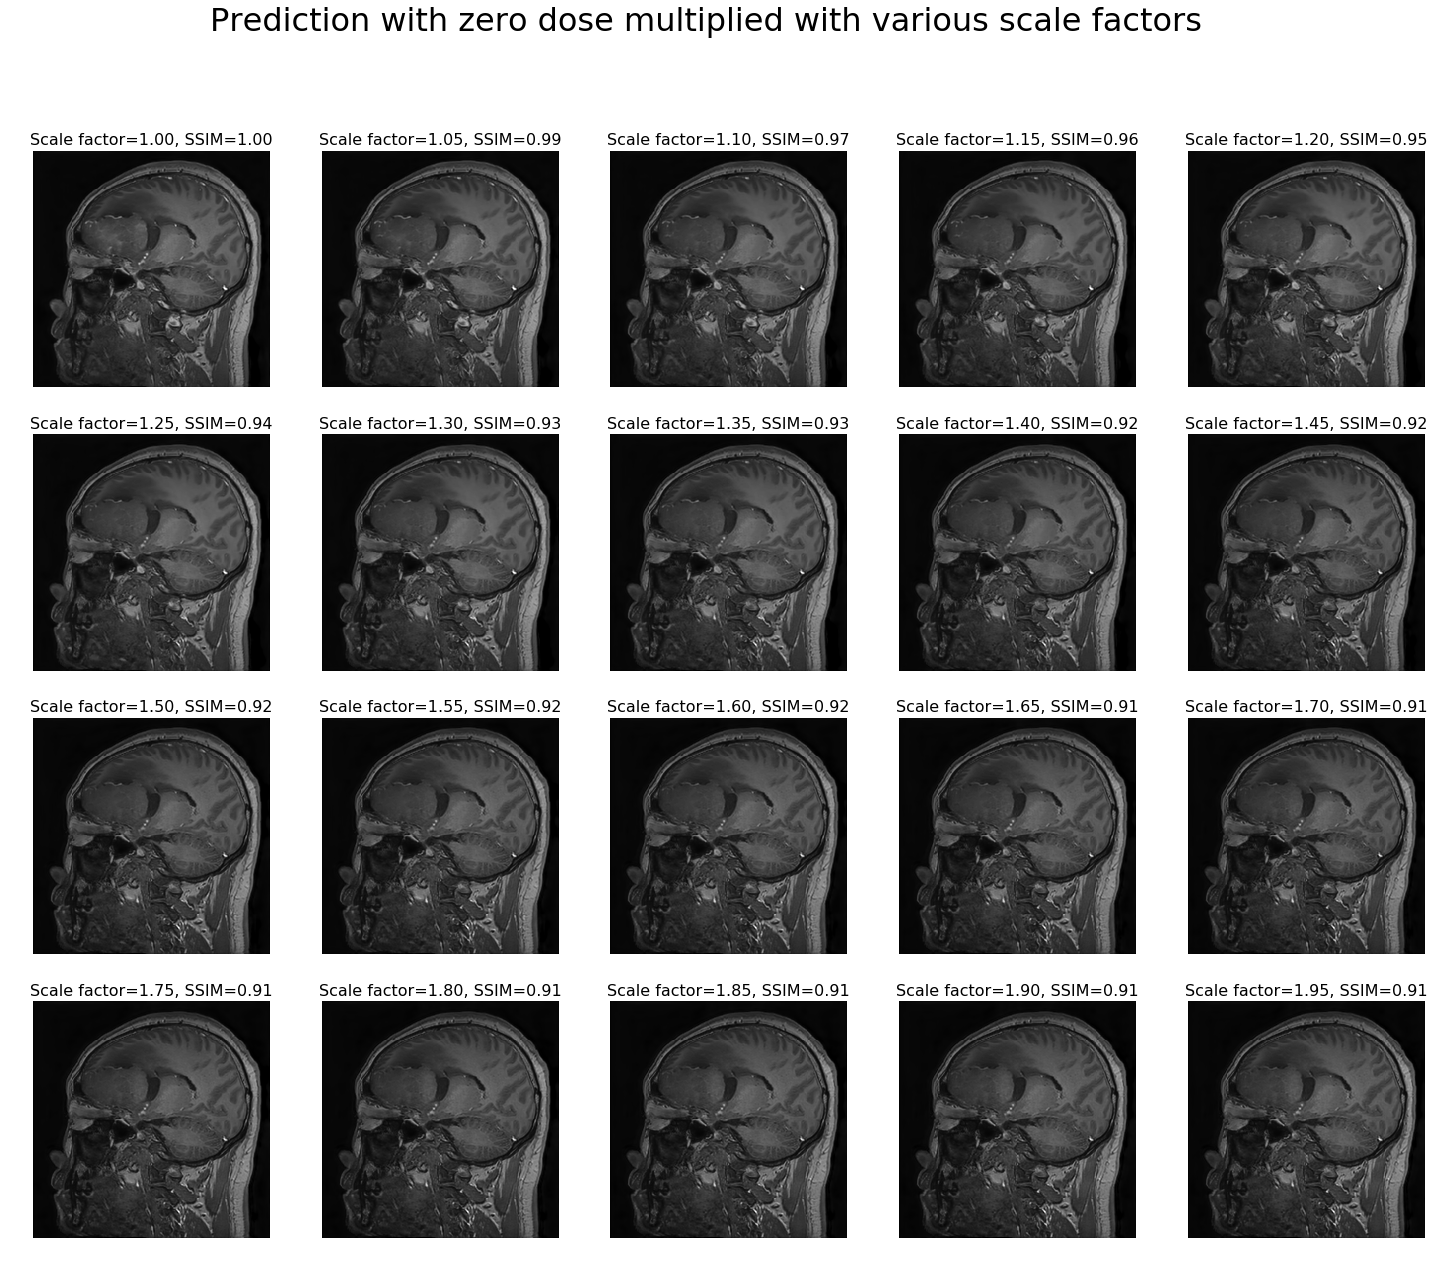

In [42]:
fig = plt.figure(figsize=(25, 20))
fig.tight_layout()

for i, sf in enumerate(np.linspace(1, 2, 21)[:-1]):
    np_path = '{}/zero_predmod_{:.2f}.npy'.format(dirpath_npy, sf)
    pmod = np.load(np_path)
    
    fig.add_subplot(4, 5, i+1)
    plt.imshow(pmod[pidx])
    plt.axis('off')
    plt.title('Scale factor={:.2f}, SSIM={:.2f}'.format(sf, ssims[i]), fontsize=16)
plt.suptitle('Prediction with zero dose multiplied with various scale factors', fontsize=32)
plt.savefig('/home/srivathsa/projects/scale-factor-zero-1.png')

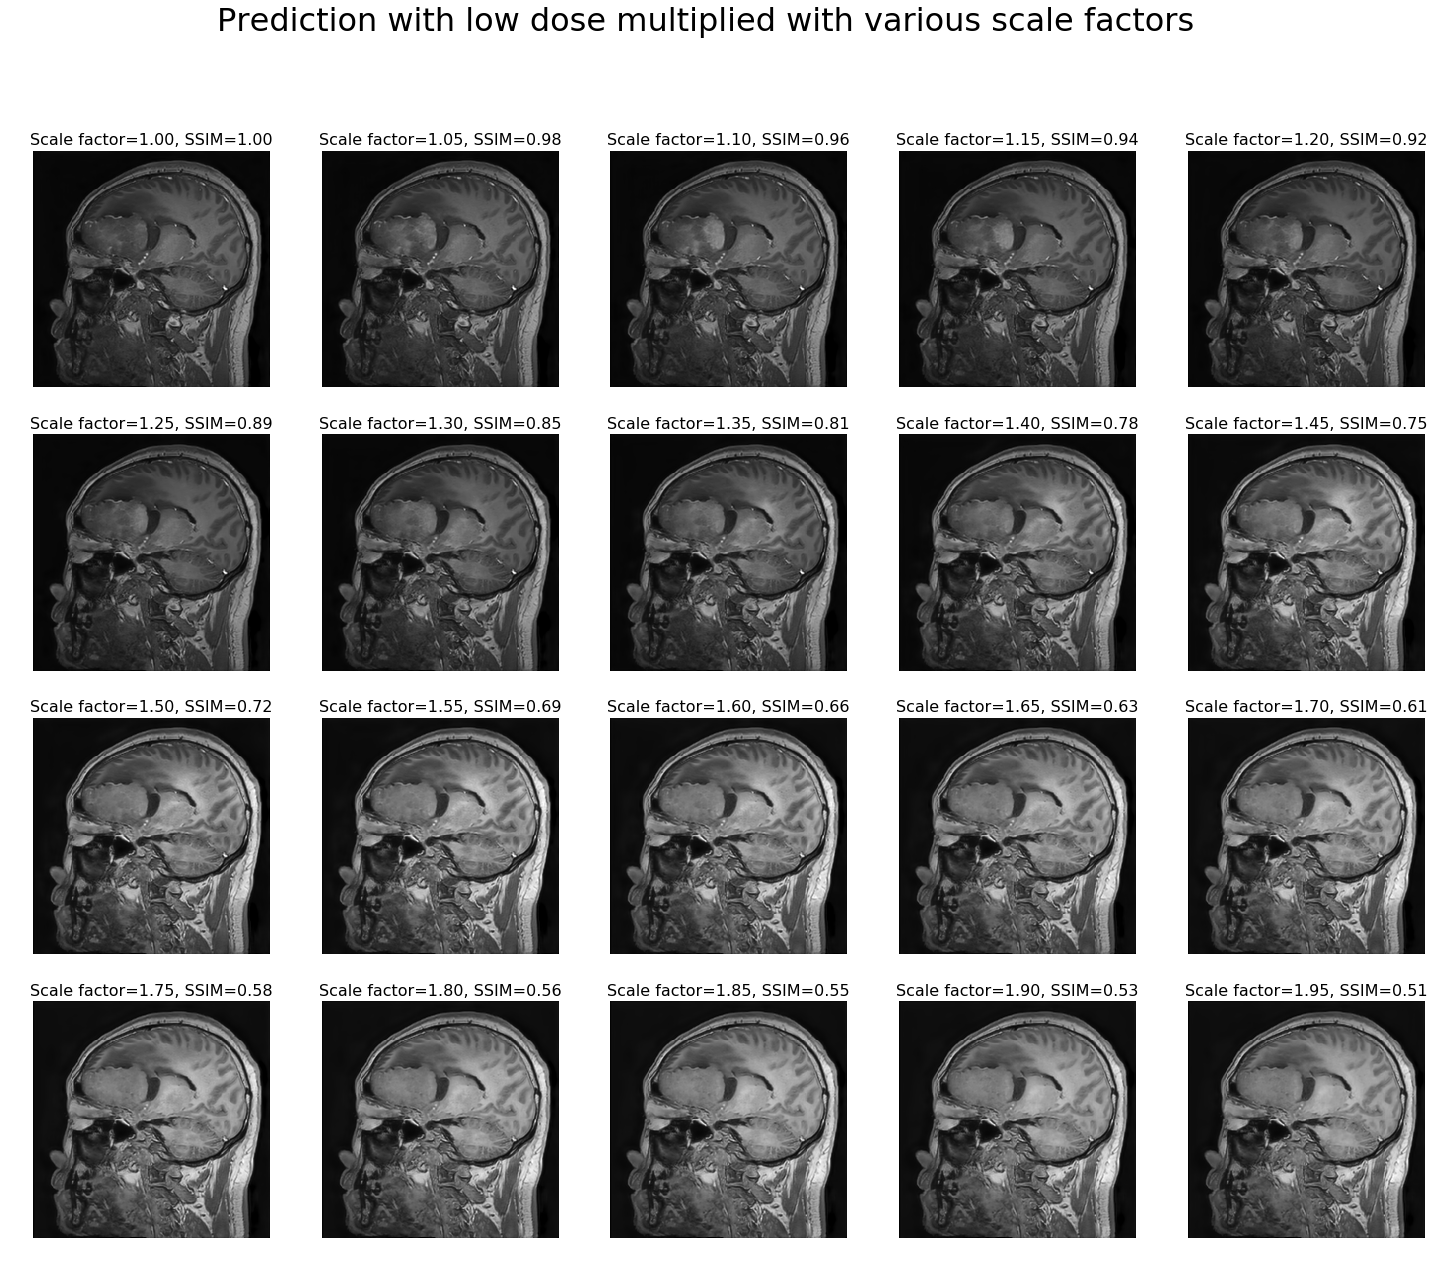

In [44]:
fig = plt.figure(figsize=(25, 20))
fig.tight_layout()

for i, sf in enumerate(np.linspace(1, 2, 21)[:-1]):
    np_path = '{}/low_predmod_{:.2f}.npy'.format(dirpath_npy, sf)
    pmod = np.load(np_path)
    
    fig.add_subplot(4, 5, i+1)
    plt.imshow(pmod[pidx])
    plt.axis('off')
    plt.title('Scale factor={:.2f}, SSIM={:.2f}'.format(sf, ssims[i]), fontsize=16)
plt.suptitle('Prediction with low dose multiplied with various scale factors', fontsize=32)
plt.savefig('/home/srivathsa/projects/scale-factor-low-1.png')

## Relative Scaling - Manual

In [74]:
base_ims = np.load('/home/srivathsa/projects/studies/gad/tiantan/inference/test/NO31_onlyreg.npy')

@interact
def relative_scaling(idx=(0, 195, 1), sf=(0, 2, 0.01)):
    zero = base_ims[idx, 0]
    low = base_ims[idx, 1]
    sf_low = base_ims[idx, 1] * sf
    
    diff = sf_low - zero
    abs_diff = np.abs(diff)
    fig = plt.figure(figsize=(16, 14))
    fig.tight_layout()

    fig.add_subplot(2, 2, 1)
    plt.imshow(zero, vmin=zero.min(), vmax=zero.max())
    plt.title('Zero dose')
    plt.axis('off')
    
    fig.add_subplot(2, 2, 2)
    plt.imshow(sf_low, vmin=zero.min(), vmax=zero.max())
    plt.title('Low dose * {}'.format(sf))
    plt.axis('off')
    
    fig.add_subplot(2, 2, 3)
    plt.imshow(diff)
    plt.title('Low - Zero')
    plt.axis('off')
    plt.colorbar()
    
    
    fig.add_subplot(2, 2, 4)
    plt.imshow(abs_diff ** 0.6, clim=[0,30])
    plt.title('Abs(low - zero)')
    plt.axis('off')
    plt.colorbar()

interactive(children=(IntSlider(value=97, description='idx', max=195), FloatSlider(value=1.0, description='sf'…